In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator,QiskitRuntimeService
from qiskit_aer import AerSimulator
import numpy as np
from qiskit.visualization import plot_histogram
from qiskit import transpile


In [3]:
n=3
iterations =  int((np.pi*np.sqrt(np.power(2,n)))//4)
Size= np.power(2,n)
print(f"Array Size: {Size}")
print(iterations)

Array Size: 8
2


In [4]:
# Classical solution
db = [] # 2^n in size - we will randomly assign the elements to be 0 or 1
for i in range(Size):
    element= np.random.randint(0,2)
    db.append(element)
print(db)

solIndices = [i for i, x in enumerate(db) if x == 1]

m = len(solIndices)

print(f"M = {m} and Indices of solutions = {solIndices}")

[0, 0, 0, 1, 0, 0, 1, 0]
M = 2 and Indices of solutions = [3, 6]


In [5]:
def createGroverircuit(n, solution_indices, iterations):
    
    groverQ = QuantumRegister(n, name='logical')
    groverCbit = ClassicalRegister(n, name='result')
    ancilla = QuantumRegister(2, name='anc')
    
    qc = QuantumCircuit(groverQ, ancilla, groverCbit)
    
    # Initialize to + state n qubits
    qc.h(groverQ)
    qc.barrier()
    
    for i in range(iterations):
        
        qc.x(ancilla[0])
        qc.h(ancilla[0])
        
        
        for target_idx in solution_indices:
            
            target_binary = format(target_idx, f'0{n}b')
            
            for j in range(n):
                if target_binary[j] == '0':
                    qc.x(groverQ[n-j-1])  # Reverse order to match qubit ordering
            
            # Apply MCX
            qc.mcx(groverQ, ancilla[0])
            
            # Undo X gates
            for j in range(n):
                if target_binary[j] == '0':
                    qc.x(groverQ[n-j-1])
        
        # Reverse ancilla[0] to ground state
        qc.h(ancilla[0])
        qc.x(ancilla[0])
        qc.barrier(groverQ, ancilla[0])
        
        # Diffuser Step
        qc.h(groverQ)
        qc.barrier()
        
        # Prepare ancilla |->
        qc.x(ancilla[1])
        qc.h(ancilla[1])
        
        # Apply Z0 GATE
        qc.x(groverQ)
        qc.mcx(groverQ, ancilla[1])
        qc.x(groverQ)
        
        # Reverse ancilla[1] to ground state
        qc.h(ancilla[1])
        qc.x(ancilla[1])
        qc.barrier()
        
        # Apply H gates again
        qc.h(groverQ)
        qc.barrier()
    
    qc.measure(groverQ, groverCbit)
    return qc

In [6]:
def GAS(n, target_indices, max_attempts=n):
    
    N = 2**n
    
    T = 1
    
    for attempt in range(max_attempts):
        print(f"Attempt {attempt+1}, T = {T}")
        
        iterations = np.random.randint(1, T+1)
        print(f"Running with {iterations} iterations")
        
        
        qc = createGroverircuit(n, target_indices, iterations)
        backend = AerSimulator()
        sampler = Sampler(mode=backend)
        transpiled_qc = transpile(qc)
        # job = sampler.run([transpiled_qc], shots=1024)  # Wrap circuit in a list
        pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
        job = sampler.run(pm.run([transpiled_qc]),shots=1024)
        counts = job.result()[0].data.result.get_counts()
        
        
            
        T = int(1.25 * T) 
        
    return counts, qc

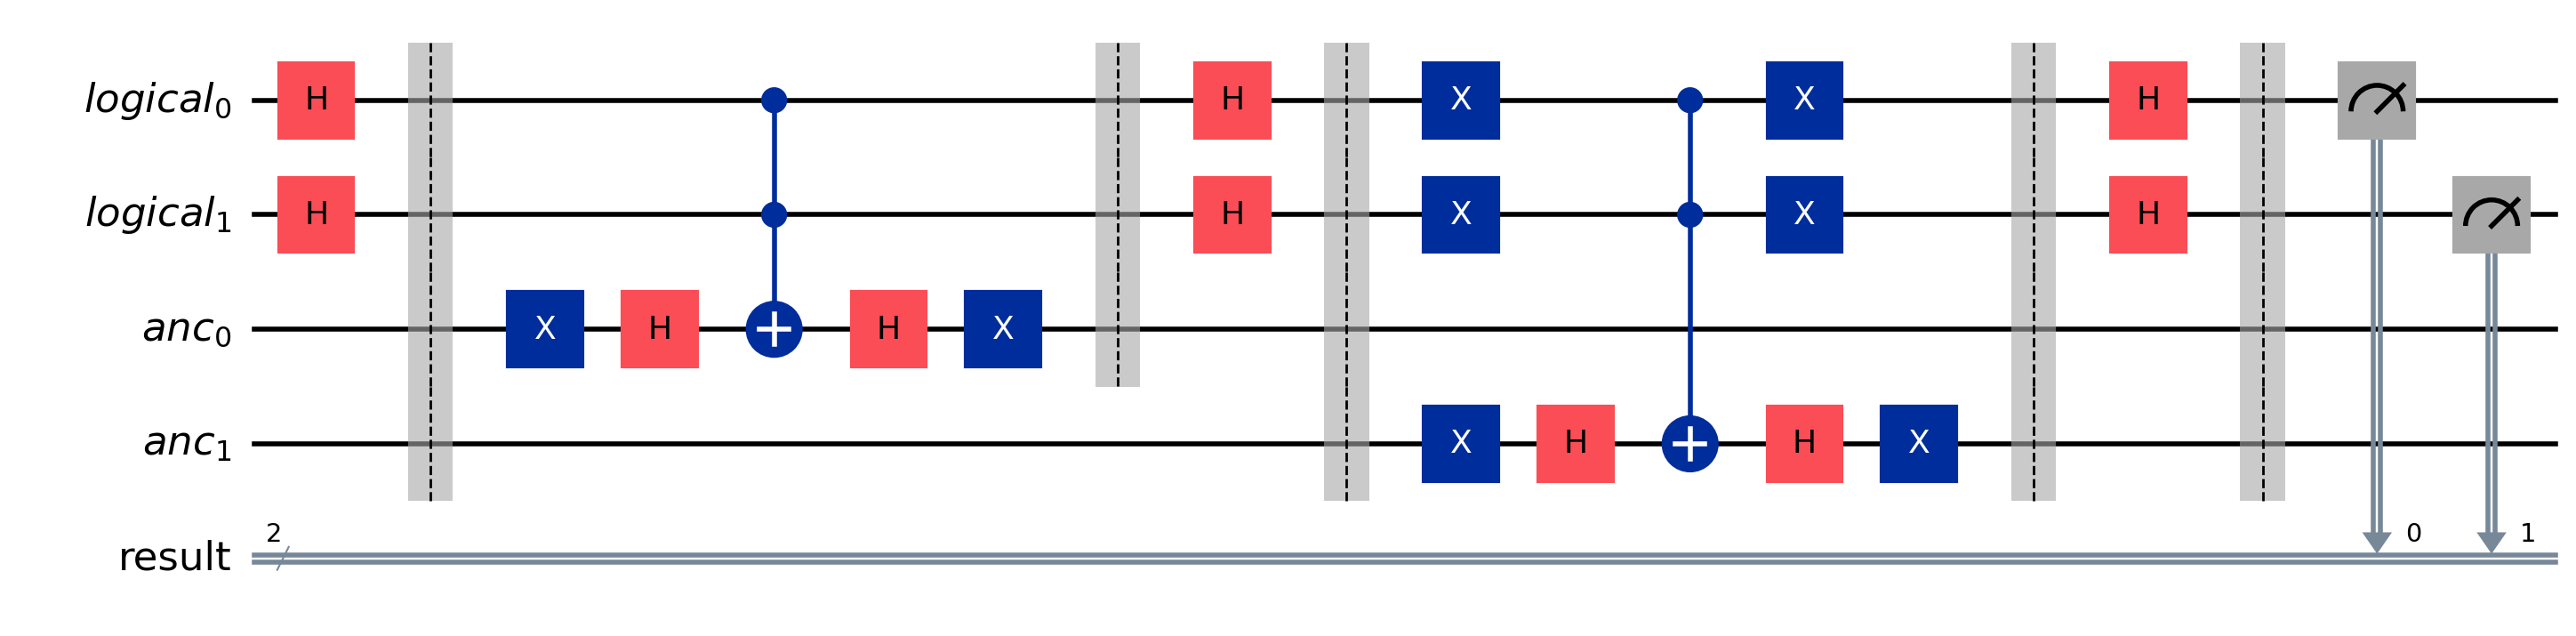

In [45]:

groverQ= QuantumRegister(n,name='logical')
groverCbit= ClassicalRegister(n,name='result')

ancilla= QuantumRegister(2,name='anc')


qc= QuantumCircuit(groverQ,ancilla,groverCbit)

# Initialise to + state n qubits
qc.h(groverQ)
qc.barrier()
for i in range(iterations):
    # Applying G=H x Z0 x H x Zf  t times

    ## Mirror image step
    # Apply Zf gate= C^5X on |-> state ancilla[0] =>
    qc.x(ancilla[0])
    qc.h(ancilla[0])

    qc.mcx(groverQ,ancilla[0])
    # Reverse ancilla[0] to ground state
    qc.h(ancilla[0])
    qc.x(ancilla[0])
    qc.barrier(groverQ,ancilla[0])
    
    ### Diffuser Step

    # Apply H gates again
    qc.h(groverQ)
    qc.barrier()
    # Prepare ancilla |->
    qc.x(ancilla[1])
    qc.h(ancilla[1])
    # Apply Z0 GATE
    qc.x(groverQ)
    qc.mcx(groverQ,ancilla[1])
    qc.x(groverQ)
    # reverse ancilla[1] to ground state
    qc.h(ancilla[1])
    qc.x(ancilla[1])
    qc.barrier()

    # Apply H gates again
    qc.h(groverQ)
    qc.barrier()

qc.measure(groverQ,groverCbit)
qc.draw('mpl', scale=2.0,fold=-1)

In [10]:
transpiled_qc= transpile(qc)
service = QiskitRuntimeService(name="qgss-2025")

# Get a backend

backend = AerSimulator()
#backend = service.least_busy(operational=True, simulator=False)
#backend= service.backend(name='ibm_torino')
print(f"We are using the {backend.name} quantum computer")

sampler = Sampler(mode=backend)

We are using the aer_simulator quantum computer


In [11]:
# Submit the circuit to Sampler
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
job = sampler.run(pm.run([transpiled_qc]),shots=1024)

# Get the results
results = job.result()[0].data

{'1111111': 1021, '0111101': 1, '1110100': 1, '1001010': 1}


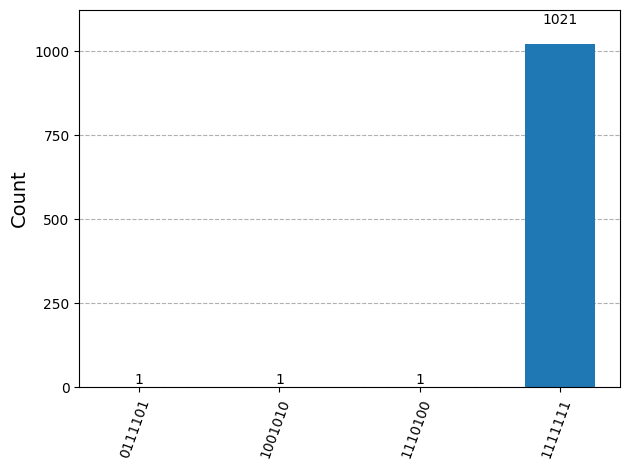

In [12]:
counts= results.result.get_counts()
print(counts)
plot_histogram(counts)

Running Grover Adaptive Search with unknown number of solutions
Attempt 1, T = 1
Running with 1 iterations
Attempt 2, T = 1
Running with 1 iterations
Attempt 3, T = 1
Running with 1 iterations


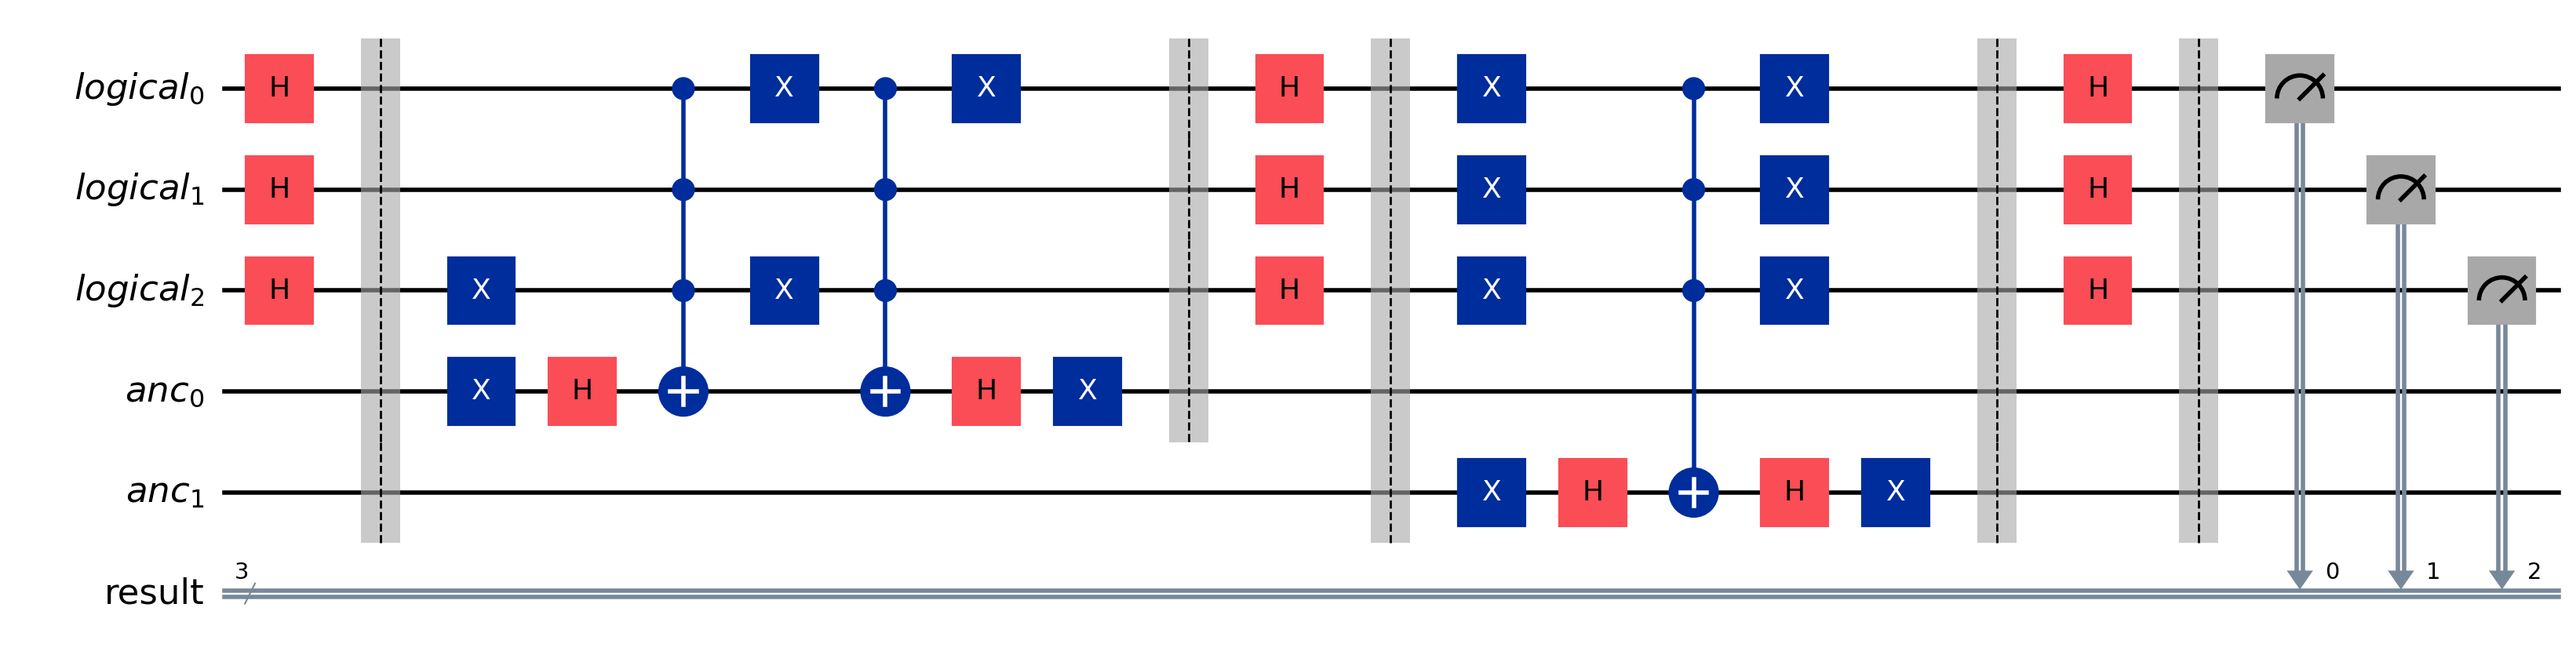

In [8]:
# adaptive search
print("Running Grover Adaptive Search with unknown number of solutions")
final_counts, qc = GAS(n, solIndices)

qc.draw('mpl', scale=2.0)



In [ ]:
# fig = qc.draw('mpl', scale=2.0, fold=-1)
# fig.tight_layout()  
# fig.show()

plot_histogram(final_counts)